# Show block arrival times per node for a given date range
See .env.example to set the environment variables.

In [5]:
!pip install jupysql clickhouse_sqlalchemy matplotlib python-dotenv > /dev/null 2>&1

In [11]:
import dotenv
import os

dotenv.load_dotenv()

# Load and display config
start_slot = int(os.getenv('START_SLOT'))
end_slot = int(os.getenv('END_SLOT'))

validator_ranges_url = os.getenv('VALIDATOR_RANGES_URL')

network = os.getenv('NETWORK')

print(f"start_slot: {start_slot}")
print(f"end_slot: {end_slot}")
print(f"validator_ranges_url: {validator_ranges_url}")
print(f"network: {network}")

ignored_nodes = os.getenv('IGNORED_NODES')
print(f"ignored_nodes: {ignored_nodes}")

consensus_clients = os.getenv('CONSENSUS_CLIENTS', '')
execution_clients = os.getenv('EXECUTION_CLIENTS', '')

consensus_clients = [client.strip() for client in consensus_clients.split(',') if client.strip()]
execution_clients = [client.strip() for client in execution_clients.split(',') if client.strip()]

if consensus_clients:
    print(f"Only looking at the following consensus clients: {consensus_clients}")
else:
    print(f"Looking at all consensus clients")
if execution_clients:
    print(f"Only looking at the following execution clients: {execution_clients}")
else:
    print(f"Looking at all execution clients")

beacon_node_url = os.getenv('BEACON_NODE_URL')
if not beacon_node_url:
    raise ValueError("No beacon node URL provided")


start_slot: 7000
end_slot: 10000
validator_ranges_url: https://bootnode-1.mekong-devnet-0.ethpandaops.io/meta/api/v1/validator-ranges.json
network: mekong-devnet-0
ignored_nodes: 
Only looking at the following consensus clients: ['nimbus', 'teku', 'lodestar', 'prysm', 'grandine', 'lighthouse']
Only looking at the following execution clients: ['geth', 'erigon', 'nethermind', 'besu', 'reth', 'nimbusel', 'ethereumjs']


In [12]:
# Load validator ranges
import requests

from datetime import datetime

response = requests.get(validator_ranges_url)
validator_ranges = response.json()

ignored = 0

consensus_clients = os.getenv('CONSENSUS_CLIENTS', '')
execution_clients = os.getenv('EXECUTION_CLIENTS', '')

consensus_clients = [client.strip() for client in consensus_clients.split(',') if client.strip()]
execution_clients = [client.strip() for client in execution_clients.split(',') if client.strip()]

if consensus_clients:
    print(f"Only looking at the following consensus clients: {consensus_clients}")
if execution_clients:
    print(f"Only looking at the following execution clients: {execution_clients}")

def is_ignored(node):
    if ignored_nodes and node in ignored_nodes.split(','):
        print(f"Ignoring node {node} because it is in the IGNORED_NODES list")
        return True
    if consensus_clients:
        consensus_client = node.split('-')[0]
        if consensus_client not in consensus_clients:
            print(f"Ignoring node {node} because it is not in the CONSENSUS_CLIENTS list")
            return True
    if execution_clients:
        execution_client = node.split('-')[1]
        if execution_client not in execution_clients:
            print(f"Ignoring node {node} because it is not in the EXECUTION_CLIENTS list")
            return True
    return False

# Translate the validator ranges to a dictionary of validator index to node with a start and end index
validator_ranges_dict = {}
for range, node in validator_ranges['ranges'].items():
    if is_ignored(node):
        ignored += 1
        continue
    
    consensus_client = node.split('-')[0]
    execution_client = node.split('-')[1]
    start, end = range.split('-')
    validator_ranges_dict[node] = {
        'start': int(start),
        'end': int(end),
        'node': node,
        'consensus': consensus_client,
        'execution': execution_client
    }

# Show how many nodes we have
print(f"Number of nodes: {len(validator_ranges_dict)}")
print(f"Ignored nodes: {ignored}")

# Get genesis time from beacon node
genesis_response = requests.get(f"{beacon_node_url}/eth/v1/beacon/genesis")
if genesis_response.status_code != 200:
    raise ValueError("Failed to fetch genesis time")

# Convert unix timestamp to datetime
genesis_time = datetime.fromtimestamp(int(genesis_response.json()['data']['genesis_time']))

print(f"Genesis time: {genesis_time}")


# Convert start and end slots to datetime objects
start_dt = datetime.fromtimestamp(int(genesis_time.timestamp()) + (int(start_slot) * 12))
end_dt = datetime.fromtimestamp(int(genesis_time.timestamp()) + (int(end_slot) * 12))

start_date = start_dt.strftime('%Y-%m-%dT%H:%M:%S')
end_date = end_dt.strftime('%Y-%m-%dT%H:%M:%S')

# Calculate the difference in hours
hours = (end_dt - start_dt).total_seconds() / 3600

print(f"hours: {hours}")
print(f"start_dt: {start_dt}")
print(f"end_dt: {end_dt}")
print(f"start_slot: {start_slot}")
print(f"end_slot: {end_slot}")
print(f"total slots: {int(end_slot) - int(start_slot)}")



Only looking at the following consensus clients: ['nimbus', 'teku', 'lodestar', 'prysm', 'grandine', 'lighthouse']
Only looking at the following execution clients: ['geth', 'erigon', 'nethermind', 'besu', 'reth', 'nimbusel', 'ethereumjs']
Number of nodes: 118
Ignored nodes: 0
Genesis time: 2024-11-06 02:00:00
hours: 10.0
start_dt: 2024-11-07 01:20:00
end_dt: 2024-11-07 11:20:00
start_slot: 7000
end_slot: 10000
total slots: 3000


In [13]:
# Connect to ClickHouse
import os
username = os.getenv('XATU_CLICKHOUSE_USERNAME')
password = os.getenv('XATU_CLICKHOUSE_PASSWORD')
host = os.getenv('XATU_CLICKHOUSE_HOST')


db_url = f"clickhouse+http://{username}:{password}@{host}:443/default?protocol=https"

from sqlalchemy import create_engine

engine = create_engine(db_url)

connection = engine.connect()

In [26]:
# Fetch all beacon blocks from the beacon API
import requests
from dataclasses import dataclass
from datetime import datetime
import asyncio
import aiohttp
from typing import List
import nest_asyncio

# Enable nested event loops
nest_asyncio.apply()

@dataclass
class Block:
    slot: int
    proposer_index: int
    version: str

# Get blocks from beacon node API
async def get_block(session: aiohttp.ClientSession, slot: int) -> Block | None:
    url = f"{beacon_node_url}/eth/v2/beacon/blocks/{slot}"
    async with session.get(url) as response:
        if response.status == 200:
            block_data = await response.json()
            return Block(
                slot=slot,
                proposer_index=block_data['data']['message']['proposer_index'],
                version=block_data['version']
            )
    return None

async def get_blocks(start_slot: int, end_slot: int) -> List[Block]:
    blocks = []
    print(f"Fetching blocks from slot {start_slot} to {end_slot}")
    
    async with aiohttp.ClientSession() as session:
        tasks = []
        # Convert string slots to integers
        start = int(start_slot)
        end = int(end_slot)

        print(f"Fetching blocks from slot {start} to {end}")
        
        current_slot = start
        while current_slot < end:
            tasks.append(get_block(session, current_slot))
            
            # Process in batches of 10
            if len(tasks) >= 10:
                results = await asyncio.gather(*tasks)
                blocks.extend([b for b in results if b is not None])
                tasks = []
            current_slot += 1
                
        # Process remaining tasks
        if tasks:
            results = await asyncio.gather(*tasks)
            blocks.extend([b for b in results if b is not None])
            
    return blocks

if start_slot < 0:
    start_slot = 0

# Fetch blocks
blocks_proposed = asyncio.run(get_blocks(start_slot, end_slot))

if len(blocks_proposed) == 0:
    raise ValueError("No blocks found for the given time range")

min_slot = blocks_proposed[0].slot
max_slot = blocks_proposed[-1].slot

print(f"Found {len(blocks_proposed)} blocks for the given time range")


Fetching blocks from slot 7000 to 10000
Fetching blocks from slot 7000 to 10000
Found 2955 blocks for the given time range


In [101]:
# Now we want to join the proposers and the block arrival times with the validator index and the node
# Example: {'ranges': {'0-99': 'lighthouse-geth-1', '100-199': 'lighthouse-geth-2'

blocks = []
not_found = 0

# For each block that was proposed, get the node
for block in blocks_proposed:
    validator_index = int(block.proposer_index)
    slot = block.slot
    found = False
    for node, range in validator_ranges_dict.items():
        start = int(range['start'])
        end = int(range['end'])
        if start <= validator_index <= end:
            # print(f"Validator {validator_index} proposed a block from node {node} at slot {slot}")
            blocks.append({
                'slot': slot,
                'validator_index': validator_index,
                'node': node
            })
            found = True
    if not found:
        not_found += 1

print(f"Found {len(blocks)} blocks for the given time range")
print(f"Found {not_found} validators that were not on any node")

if len(blocks) == 0:
    raise ValueError("No blocks found for the given time range")


Found 2955 blocks for the given time range
Found 0 validators that were not on any node


In [117]:
from sqlalchemy import text
from datetime import timedelta
from dataclasses import dataclass
import numpy as np

@dataclass
class BlockArrivalStats:
    min: float
    max: float 
    avg: float
    p05: float
    p50: float
    p90: float
    p99: float

print(f"start_date: {start_date}")
print(f"end_date: {end_date}")

# Now get the block arrival times stats for each node
query = text("""
    SELECT 
        slot,
        min(propagation_slot_start_diff) as min_time,
        max(propagation_slot_start_diff) as max_time,
        avg(propagation_slot_start_diff) as avg_time,
        quantile(0.05)(propagation_slot_start_diff) as p05,
        quantile(0.50)(propagation_slot_start_diff) as p50,
        quantile(0.90)(propagation_slot_start_diff) as p90,
        quantile(0.99)(propagation_slot_start_diff) as p99
    FROM default.beacon_api_eth_v1_events_block 
    WHERE 
         slot_start_date_time BETWEEN toDateTime(:start_date, '') AND toDateTime(:end_date, '')
         AND meta_network_name = :network
         AND slot BETWEEN :start_slot AND :end_slot
    GROUP BY slot
""")

# Add a week to before/after the start/end date
start_date_extra = (start_dt - timedelta(days=7)).strftime('%Y-%m-%dT%H:%M:%S')
end_date_extra = (end_dt + timedelta(days=7)).strftime('%Y-%m-%dT%H:%M:%S')

result = connection.execute(query, {"start_date": start_date_extra.replace('Z', ''), "end_date": end_date_extra.replace('Z', ''), "network": network, "start_slot": start_slot, "end_slot": end_slot})
block_arrival_times = result.fetchall()

if len(block_arrival_times) == 0:
    raise ValueError("No block arrival times found for the given time range")

# Convert to a dictionary of BlockArrivalStats
block_arrival_times_dict = {
    slot: BlockArrivalStats(
        min=min_time,
        max=max_time,
        avg=avg_time,
        p05=p05,
        p50=p50,
        p90=p90,
        p99=p99
    ) for slot, min_time, max_time, avg_time, p05, p50, p90, p99 in block_arrival_times
}


print(f"Found {len(block_arrival_times_dict)} block arrival times for the given time range")


start_date: 2024-11-07T01:20:00
end_date: 2024-11-07T11:20:00
Found 2998 block arrival times for the given time range


## Perform Analysis
Calculate the perctiles for the `propagation_slot_start_diff` for each type of node (execution and consensus)

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

In [103]:

# Join the blocks with the block_arrival_times_dict. We want all the blocks that the node proposed
missing_node_blocks = {}
not_found = 0
node_blocks = {}
for block in blocks:
    slot = int(block['slot'])
    if block['node'] not in node_blocks:
        node_blocks[block['node']] = []
    # lookup the block arrival time for the slot
    if slot in block_arrival_times_dict:
        block['arrival_stats'] = block_arrival_times_dict[slot]

        node_blocks[block['node']].append(block)
    else:
        missing_node_blocks[block['node']] = missing_node_blocks.get(block['node'], 0) + 1
        not_found += 1

print(f"{not_found} of the {len(blocks)} blocks were not found in the event stream. Maybe they were never proposed? They have been excluded from the analysis.")


blocks: [{'slot': 7000, 'validator_index': 99379, 'node': 'grandine-erigon-1'}, {'slot': 7001, 'validator_index': 20541, 'node': 'prysm-reth-2'}, {'slot': 7002, 'validator_index': 60524, 'node': 'teku-nethermind-1'}, {'slot': 7003, 'validator_index': 97044, 'node': 'grandine-nethermind-3'}, {'slot': 7004, 'validator_index': 4277, 'node': 'prysm-geth-5'}, {'slot': 7005, 'validator_index': 17376, 'node': 'prysm-nethermind-6'}, {'slot': 7006, 'validator_index': 53606, 'node': 'teku-geth-4'}, {'slot': 7007, 'validator_index': 47670, 'node': 'lighthouse-besu-2'}, {'slot': 7008, 'validator_index': 55245, 'node': 'teku-geth-6'}, {'slot': 7009, 'validator_index': 55582, 'node': 'teku-geth-6'}, {'slot': 7010, 'validator_index': 10837, 'node': 'prysm-geth-12'}, {'slot': 7011, 'validator_index': 81274, 'node': 'nimbus-geth-2'}, {'slot': 7012, 'validator_index': 90460, 'node': 'grandine-geth-1'}, {'slot': 7013, 'validator_index': 88273, 'node': 'nimbus-reth-1'}, {'slot': 7014, 'validator_index': 9

In [ ]:
# Sort missing_node_blocks by count in descending order
sorted_missing_blocks = sorted(missing_node_blocks.items(), key=lambda x: x[1], reverse=True)

# Prepare data for plotting
nodes = [item[0] for item in sorted_missing_blocks]
missing_counts = [item[1] for item in sorted_missing_blocks]

# Create a color palette based on consensus clients
consensus_clients = [node.split('-')[0] for node in nodes]
unique_clients = sorted(set(consensus_clients))
color_palette = plt.colormaps['tab10'](np.linspace(0, 1, len(unique_clients)))
colors = [color_palette[unique_clients.index(client)] for client in consensus_clients]

# Plotting
plt.figure(figsize=(14, 10))
bars = plt.bar(nodes, missing_counts, color=colors)

# Customize the plot
plt.title(f"Missing Blocks per Node\nNetwork: {network} (Slot {min_slot} -> {max_slot})", 
          fontsize=16)
plt.xlabel("Node", fontsize=14)
plt.ylabel("Number of Missing Blocks", fontsize=14)
plt.xticks(rotation=90, ha='right', fontsize=8)
plt.yticks(fontsize=12)

# Add value labels on top of each bar
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height,
             f'{height}',
             ha='center', va='bottom', fontsize=8)

# Add a grid for better readability
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Add a legend for consensus clients
legend_elements = [plt.Rectangle((0,0),1,1, facecolor=color_palette[i], edgecolor='none', label=client)
                   for i, client in enumerate(unique_clients)]
plt.legend(handles=legend_elements, title="Consensus Clients", loc='upper right')

# Improve layout and show plot
plt.tight_layout()
plt.show()

# Print detailed results
print("Missing blocks per node:")
for node, count in sorted_missing_blocks:
    print(f"{node}: {count}")

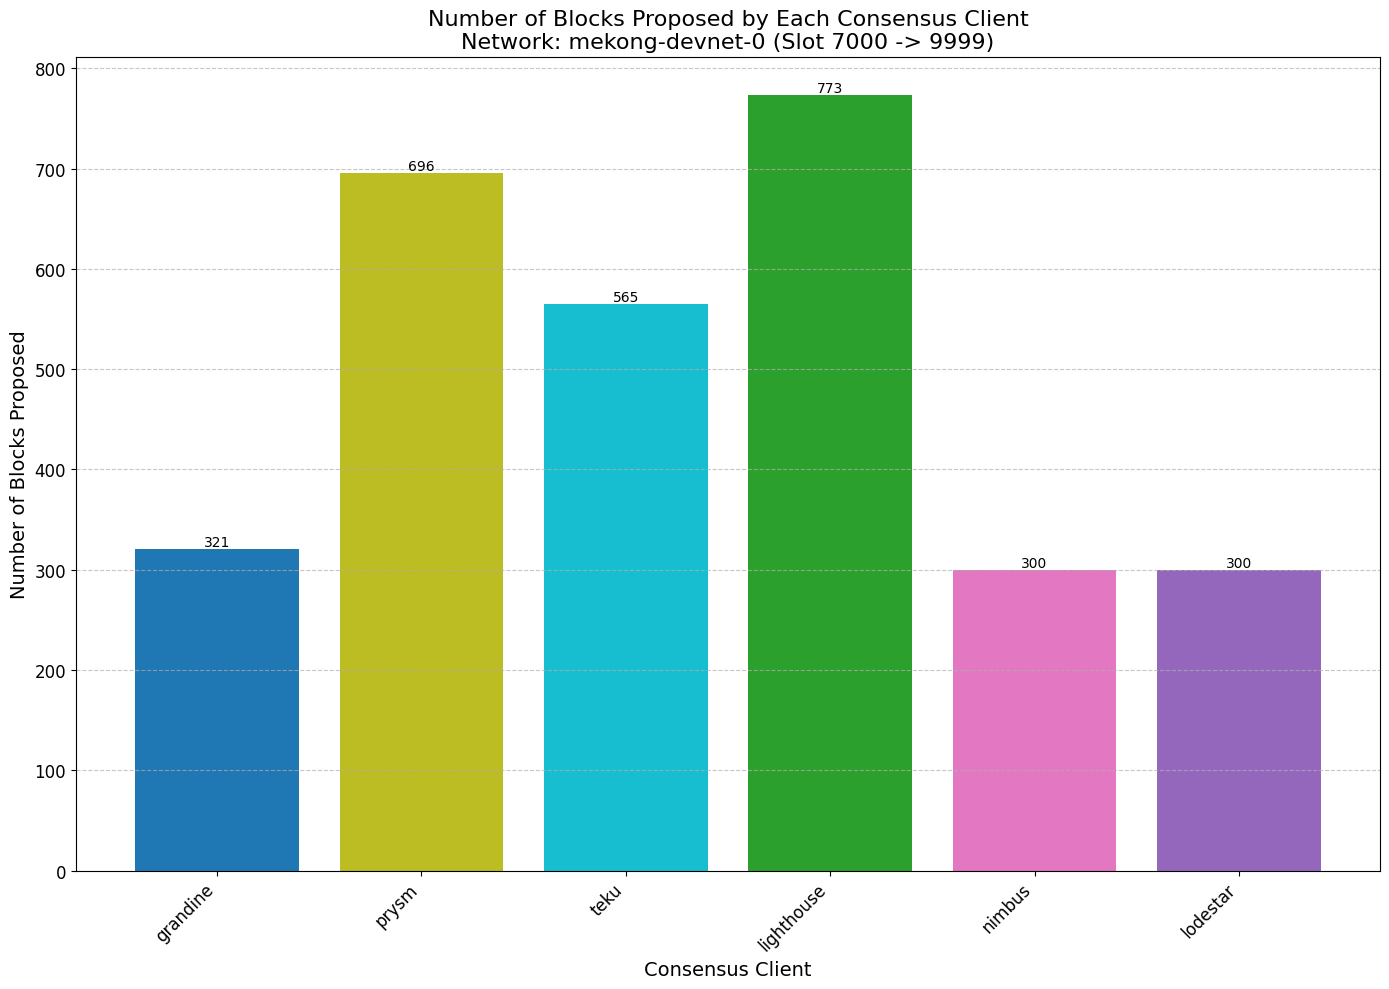

In [105]:
# Count the number of blocks proposed by each consensus client
consensus_client_counts = {}
for node, blocks in node_blocks.items():
    consensus_client = node.split('-')[0]
    consensus_client_counts[consensus_client] = consensus_client_counts.get(consensus_client, 0) + len(blocks)

# Prepare data for plotting
consensus_clients = list(consensus_client_counts.keys())
block_counts = list(consensus_client_counts.values())

# Create a color palette based on consensus clients
unique_clients = sorted(set(consensus_clients))
color_palette = plt.colormaps['tab10'](np.linspace(0, 1, len(unique_clients)))
colors = [color_palette[unique_clients.index(client)] for client in consensus_clients]

# Plotting
plt.figure(figsize=(14, 10))
bars = plt.bar(consensus_clients, block_counts, color=colors)

# Customize the plot
plt.title(f"Number of Blocks Proposed by Each Consensus Client\nNetwork: {network} (Slot {min_slot} -> {max_slot})", 
          fontsize=16)
plt.xlabel("Consensus Client", fontsize=14)
plt.ylabel("Number of Blocks Proposed", fontsize=14)
plt.xticks(rotation=45, ha='right', fontsize=12)
plt.yticks(fontsize=12)

# Add value labels on top of each bar
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height,
             f'{height}',
             ha='center', va='bottom', fontsize=10)

# Add a grid for better readability
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Improve layout and show plot
plt.tight_layout()
plt.show()

# Print detailed results (uncomment if needed)
# for client, count in consensus_client_counts.items():
#     print(f"{client} proposed {count} blocks")

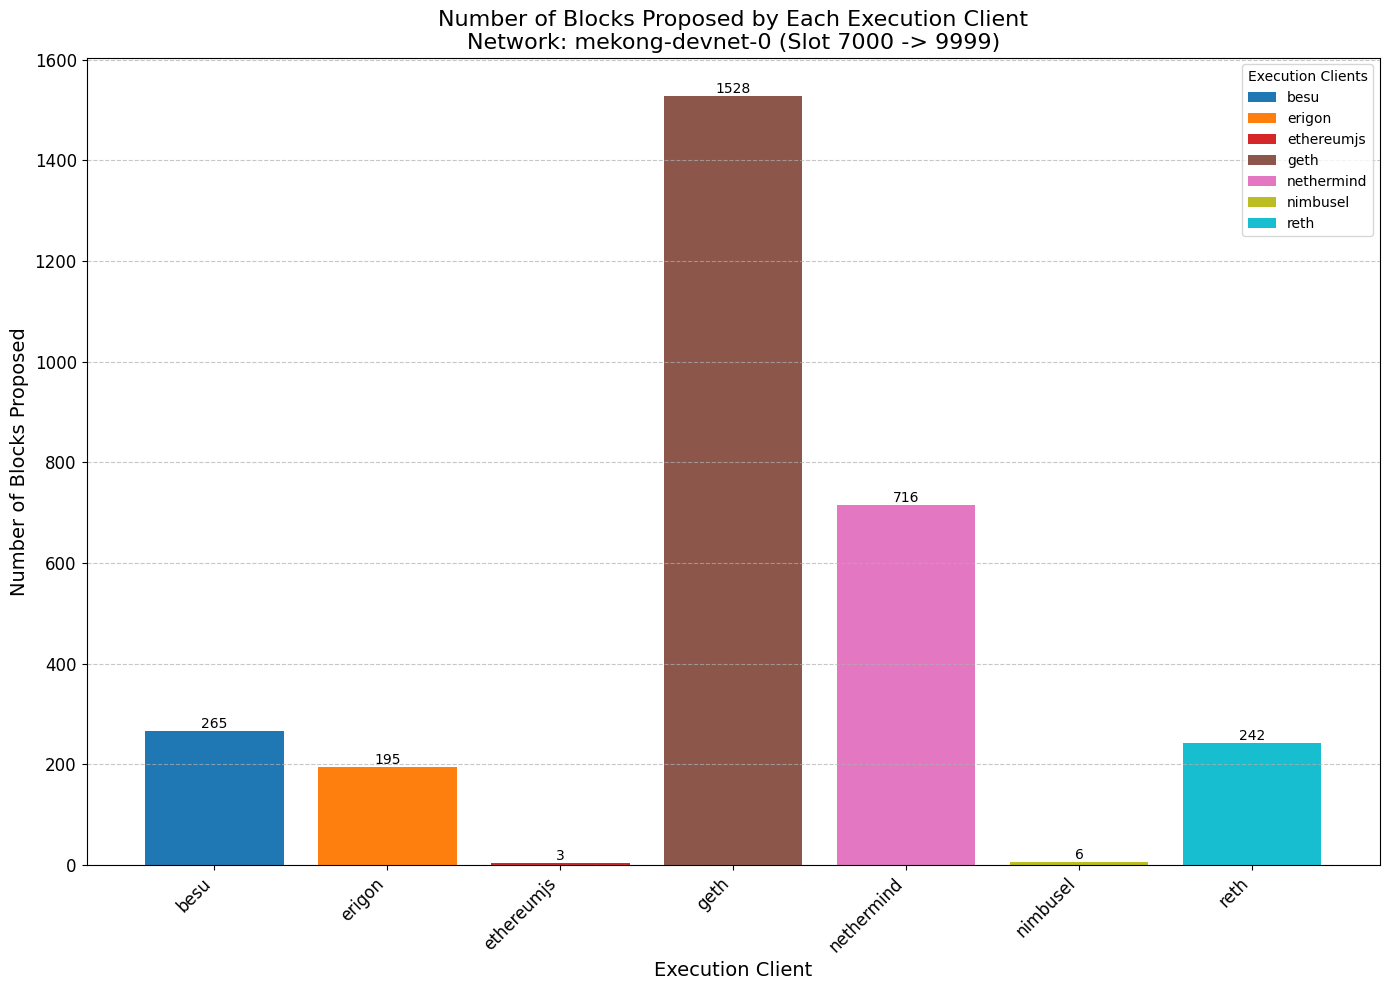

In [106]:
# Count the number of blocks proposed by each execution client
execution_client_counts = {}
for node, blocks in node_blocks.items():
    execution_client = node.split('-')[1]
    execution_client_counts[execution_client] = execution_client_counts.get(execution_client, 0) + len(blocks)

# Sort execution clients alphabetically
sorted_execution_clients = sorted(execution_client_counts.keys())

# Prepare data for plotting
block_counts = [execution_client_counts[client] for client in sorted_execution_clients]

# Create a color palette based on execution clients
unique_clients = sorted(set(sorted_execution_clients))
color_palette = plt.colormaps['tab10'](np.linspace(0, 1, len(unique_clients)))
colors = [color_palette[unique_clients.index(client)] for client in sorted_execution_clients]

# Plotting
plt.figure(figsize=(14, 10))
bars = plt.bar(sorted_execution_clients, block_counts, color=colors)

# Customize the plot
plt.title(f"Number of Blocks Proposed by Each Execution Client\nNetwork: {network} (Slot {min_slot} -> {max_slot})", 
          fontsize=16)
plt.xlabel("Execution Client", fontsize=14)
plt.ylabel("Number of Blocks Proposed", fontsize=14)
plt.xticks(rotation=45, ha='right', fontsize=12)
plt.yticks(fontsize=12)

# Add value labels on top of each bar
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height,
             f'{height}',
             ha='center', va='bottom', fontsize=10)

# Add a grid for better readability
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Add a legend for execution clients
legend_elements = [plt.Rectangle((0,0),1,1, facecolor=color_palette[i], edgecolor='none', label=client)
                   for i, client in enumerate(unique_clients)]
plt.legend(handles=legend_elements, title="Execution Clients", loc='upper right')

# Improve layout and show plot
plt.tight_layout()
plt.show()

# Print detailed results (uncomment if needed)
# for client in sorted_execution_clients:
#     print(f"{client} proposed {execution_client_counts[client]} blocks")

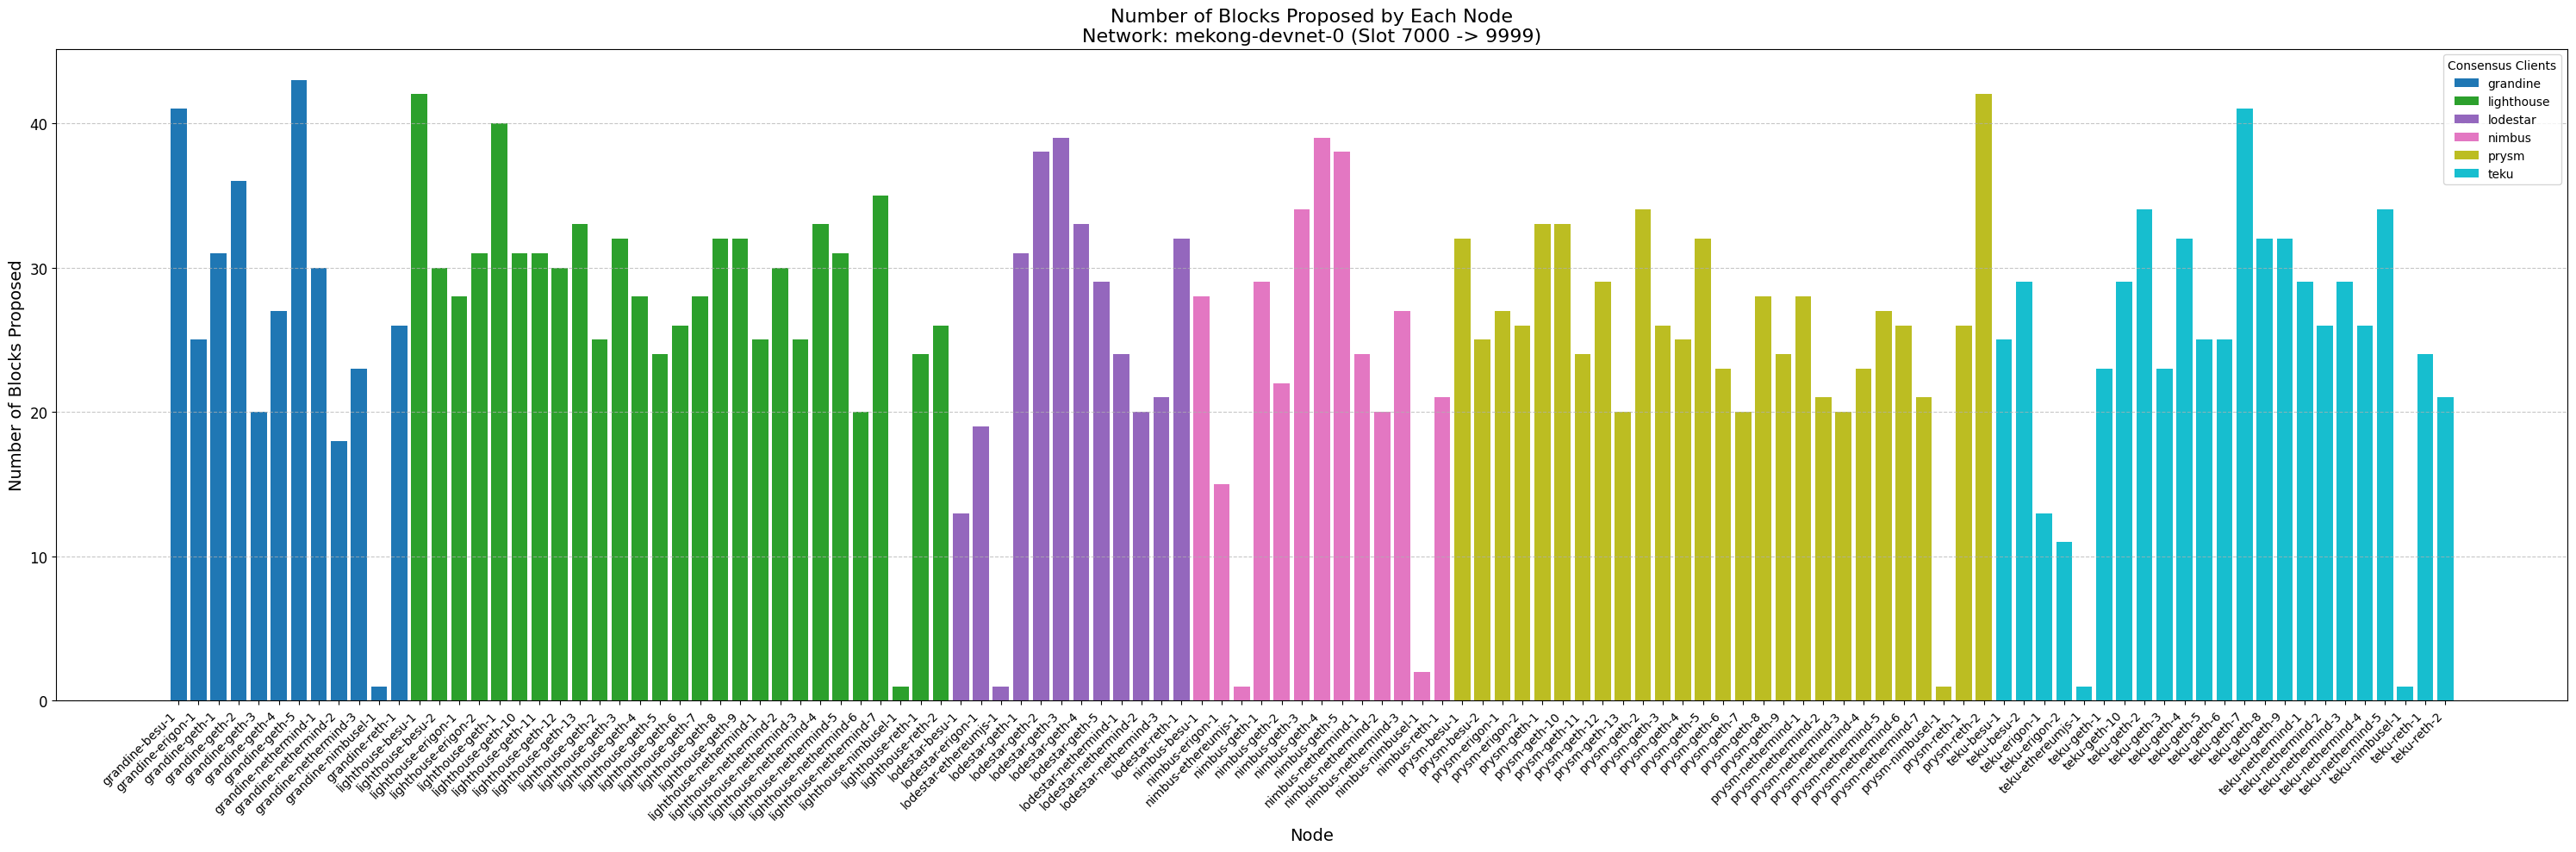

In [107]:
# Count the number of blocks proposed by each node
node_block_counts = {node: len(blocks) for node, blocks in node_blocks.items()}

# Sort nodes alphabetically
sorted_nodes = sorted(node_block_counts.keys())

# Prepare data for plotting
block_counts = [node_block_counts[node] for node in sorted_nodes]

# Create a color palette based on consensus clients
consensus_clients = [node.split('-')[0] for node in sorted_nodes]
unique_clients = sorted(set(consensus_clients))
color_palette = plt.colormaps['tab10'](np.linspace(0, 1, len(unique_clients)))
colors = [color_palette[unique_clients.index(client)] for client in consensus_clients]

# Plotting
plt.figure(figsize=(30, 10))
bars = plt.bar(sorted_nodes, block_counts, color=colors)

# Customize the plot
plt.title(f"Number of Blocks Proposed by Each Node\nNetwork: {network} (Slot {min_slot} -> {max_slot})", 
          fontsize=16)
plt.xlabel("Node", fontsize=14)
plt.ylabel("Number of Blocks Proposed", fontsize=14)
plt.xticks(rotation=45, ha='right', fontsize=10)
plt.yticks(fontsize=12)

# Add a grid for better readability
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Add a legend for consensus clients
legend_elements = [plt.Rectangle((0,0),1,1, facecolor=color_palette[i], edgecolor='none', label=client)
                   for i, client in enumerate(unique_clients)]
plt.legend(handles=legend_elements, title="Consensus Clients", loc='upper right')

# Improve layout and show plot
plt.tight_layout()
plt.show()

# Print detailed results (uncomment if needed)
# for node in sorted_nodes:
#     print(f"{node} proposed {node_block_counts[node]} blocks")

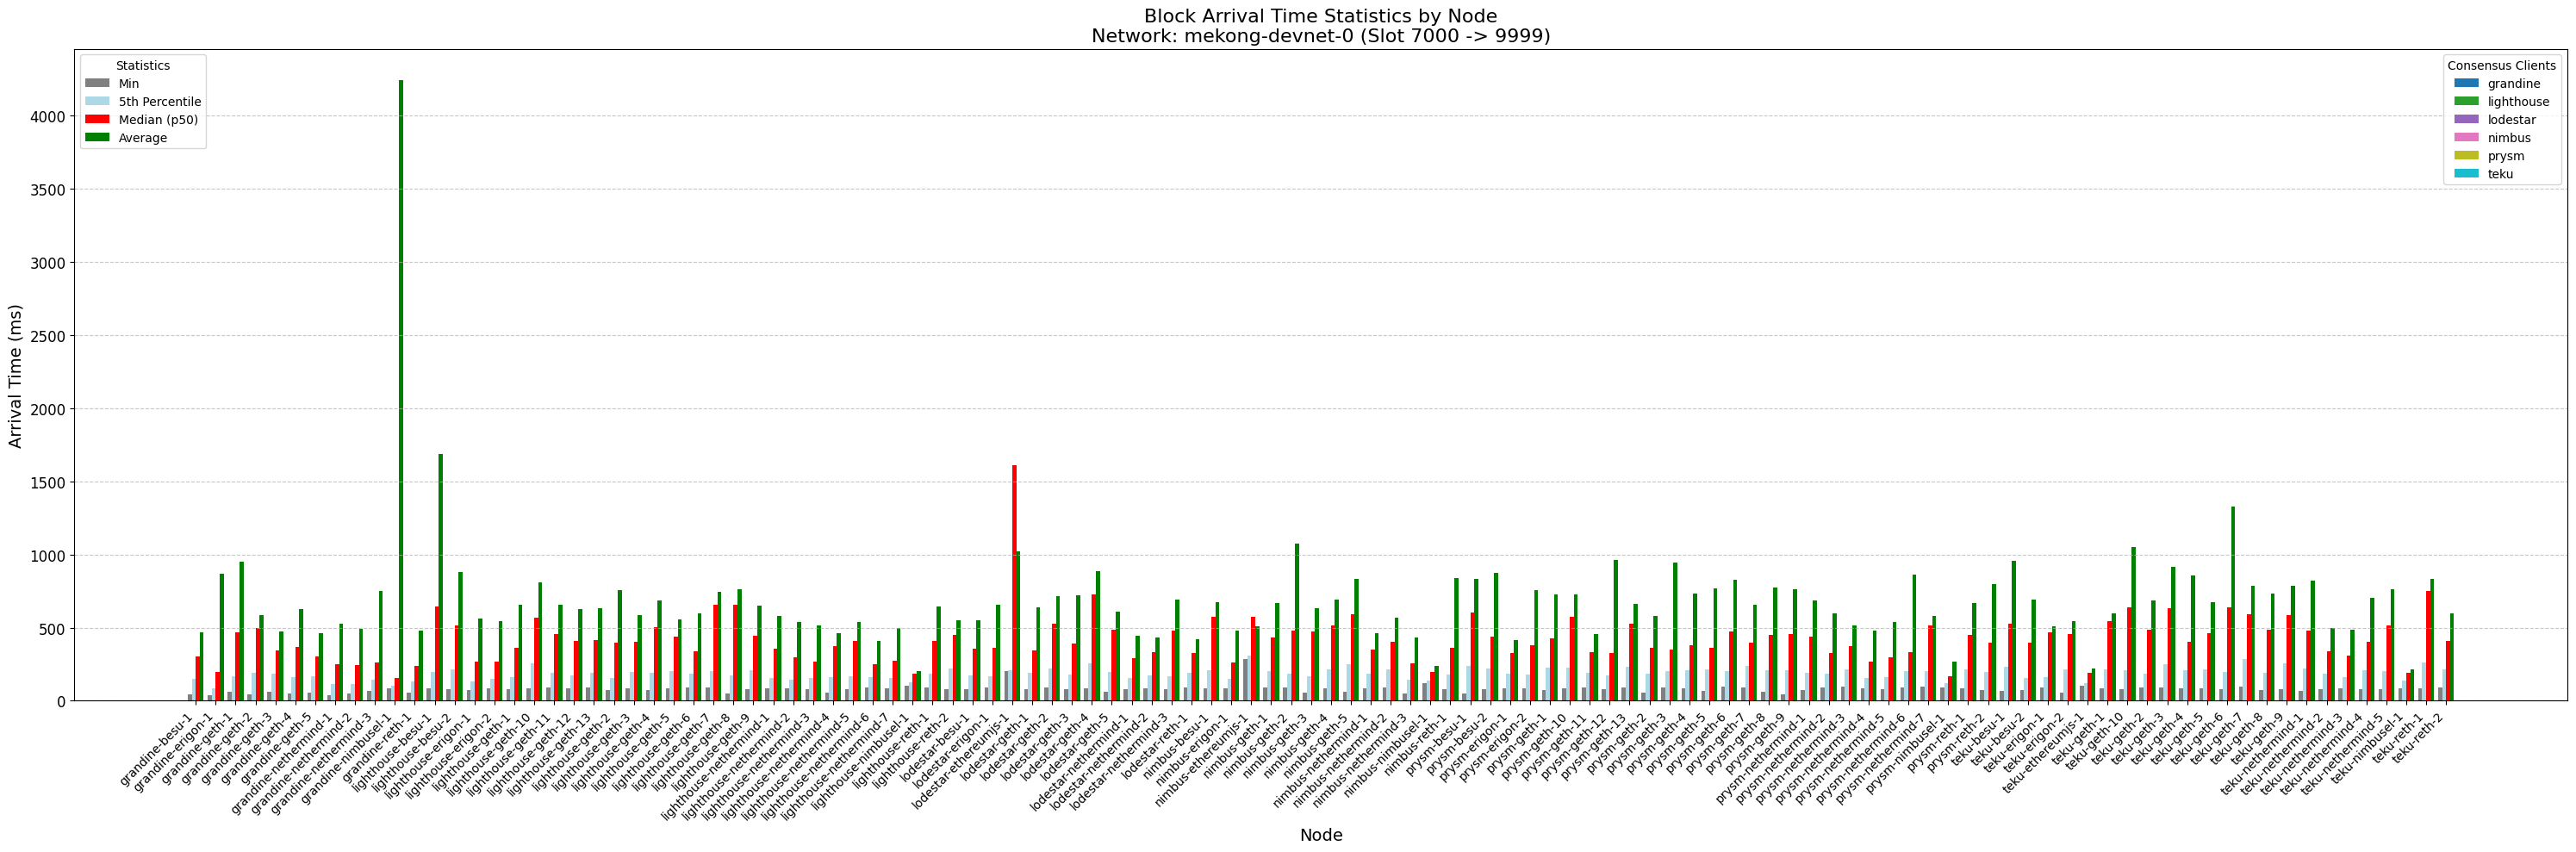

In [115]:
# Calculate block arrival time stats for each node
node_stats = {}
for node, blocks in node_blocks.items():
    if blocks:
        arrival_times = [block['arrival_stats'] for block in blocks]
        node_stats[node] = BlockArrivalStats(
            min=min(at.min for at in arrival_times),
            avg=sum(at.avg for at in arrival_times) / len(arrival_times),
            p05=sum(at.p05 for at in arrival_times) / len(arrival_times),
            p50=sum(at.p50 for at in arrival_times) / len(arrival_times),
            p90=sum(at.p90 for at in arrival_times) / len(arrival_times),
            p99=sum(at.p99 for at in arrival_times) / len(arrival_times),
            max=max(at.max for at in arrival_times)
        )
    else:
        node_stats[node] = BlockArrivalStats(
            min=float('inf'),
            avg=float('inf'),
            p05=float('inf'),
            p50=float('inf')
        )

# Sort nodes alphabetically
sorted_nodes = sorted(node_stats.keys())

# Prepare data for plotting
mins = [node_stats[node].min for node in sorted_nodes]
avgs = [node_stats[node].avg for node in sorted_nodes]
p05s = [node_stats[node].p05 for node in sorted_nodes]
p50s = [node_stats[node].p50 for node in sorted_nodes]

# Create a color palette based on consensus clients
consensus_clients = [node.split('-')[0] for node in sorted_nodes]
unique_clients = sorted(set(consensus_clients))
color_palette = plt.colormaps['tab10'](np.linspace(0, 1, len(unique_clients)))
colors = [color_palette[unique_clients.index(client)] for client in consensus_clients]

# Plotting
plt.figure(figsize=(30, 10))

# Create grouped bars
x = np.arange(len(sorted_nodes))
width = 0.2

plt.bar(x - width*1.5, mins, width, label='Min', color='gray')
plt.bar(x - width/2, p05s, width, label='5th Percentile', color='lightblue')
plt.bar(x + width/2, p50s, width, label='Median (p50)', color='red')
plt.bar(x + width*1.5, avgs, width, label='Average', color='green')

plt.xticks(x, sorted_nodes, rotation=45, ha='right', fontsize=10)

# Customize the plot
plt.title(f"Block Arrival Time Statistics by Node\nNetwork: {network} (Slot {min_slot} -> {max_slot})", 
          fontsize=16)
plt.xlabel("Node", fontsize=14)
plt.ylabel("Arrival Time (ms)", fontsize=14)
plt.yticks(fontsize=12)

# Add a grid for better readability
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Create two legend handles
stats_legend = plt.legend(title="Statistics", loc='upper left')
client_legend = [plt.Rectangle((0,0),1,1, facecolor=color_palette[i], edgecolor='none', label=client)
                for i, client in enumerate(unique_clients)]

# Add both legends
plt.gca().add_artist(stats_legend)
plt.legend(handles=client_legend, title="Consensus Clients", loc='upper right')

# Improve layout and show plot
plt.tight_layout()
plt.show()

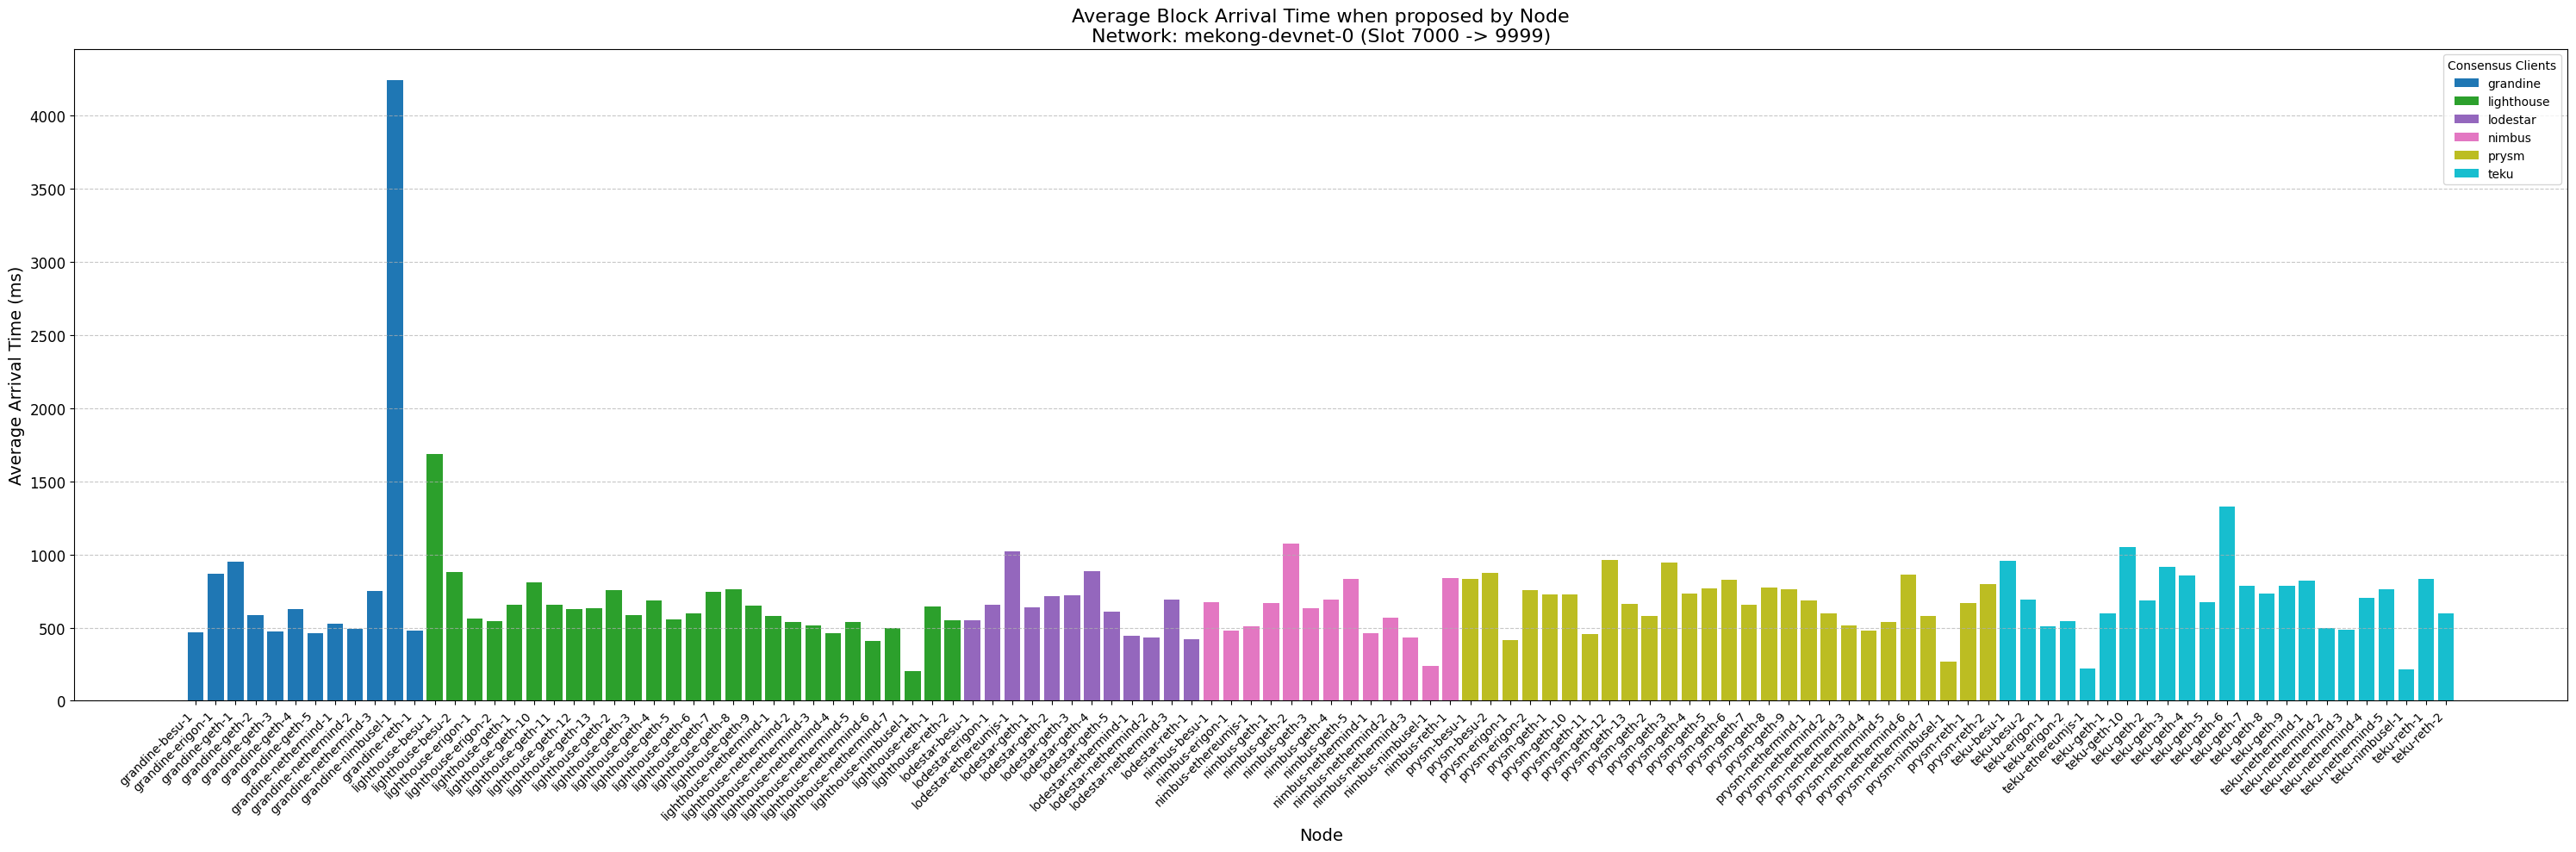

In [116]:
# Calculate average arrival time for each node, handling empty lists
avg_arrival_times = {}
for node, blocks in node_blocks.items():
    if blocks:
        avg_arrival_times[node] = sum(block['arrival_stats'].avg for block in blocks) / len(blocks)
    else:
        avg_arrival_times[node] = float('inf')  # Use infinity for nodes with no blocks

# Sort nodes alphabetically
sorted_nodes = sorted(avg_arrival_times.keys())

# Prepare data for plotting
arrival_times = [avg_arrival_times[node] for node in sorted_nodes]

# Create a color palette based on consensus clients
consensus_clients = [node.split('-')[0] for node in sorted_nodes]
unique_clients = sorted(set(consensus_clients))
color_palette = plt.colormaps['tab10'](np.linspace(0, 1, len(unique_clients)))
colors = [color_palette[unique_clients.index(client)] for client in consensus_clients]

# Plotting
plt.figure(figsize=(30, 10))
bars = plt.bar(sorted_nodes, arrival_times, color=colors)

# Customize the plot
plt.title(f"Average Block Arrival Time when proposed by Node\nNetwork: {network} (Slot {min_slot} -> {max_slot})", 
          fontsize=16)
plt.xlabel("Node", fontsize=14)
plt.ylabel("Average Arrival Time (ms)", fontsize=14)
plt.xticks(rotation=45, ha='right', fontsize=10)
plt.yticks(fontsize=12)

# Add a grid for better readability
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Add a legend for consensus clients
legend_elements = [plt.Rectangle((0,0),1,1, facecolor=color_palette[i], edgecolor='none', label=client)
                   for i, client in enumerate(unique_clients)]
plt.legend(handles=legend_elements, title="Consensus Clients", loc='upper right')

# Improve layout and show plot
plt.tight_layout()
plt.show()

# Uncomment to print detailed results
# for node in sorted_nodes:
#     if avg_arrival_times[node] != float('inf'):
#         print(f"Average arrival time for {node}: {avg_arrival_times[node]:.2f} ms")
#     else:
#         print(f"No blocks proposed by {node}")

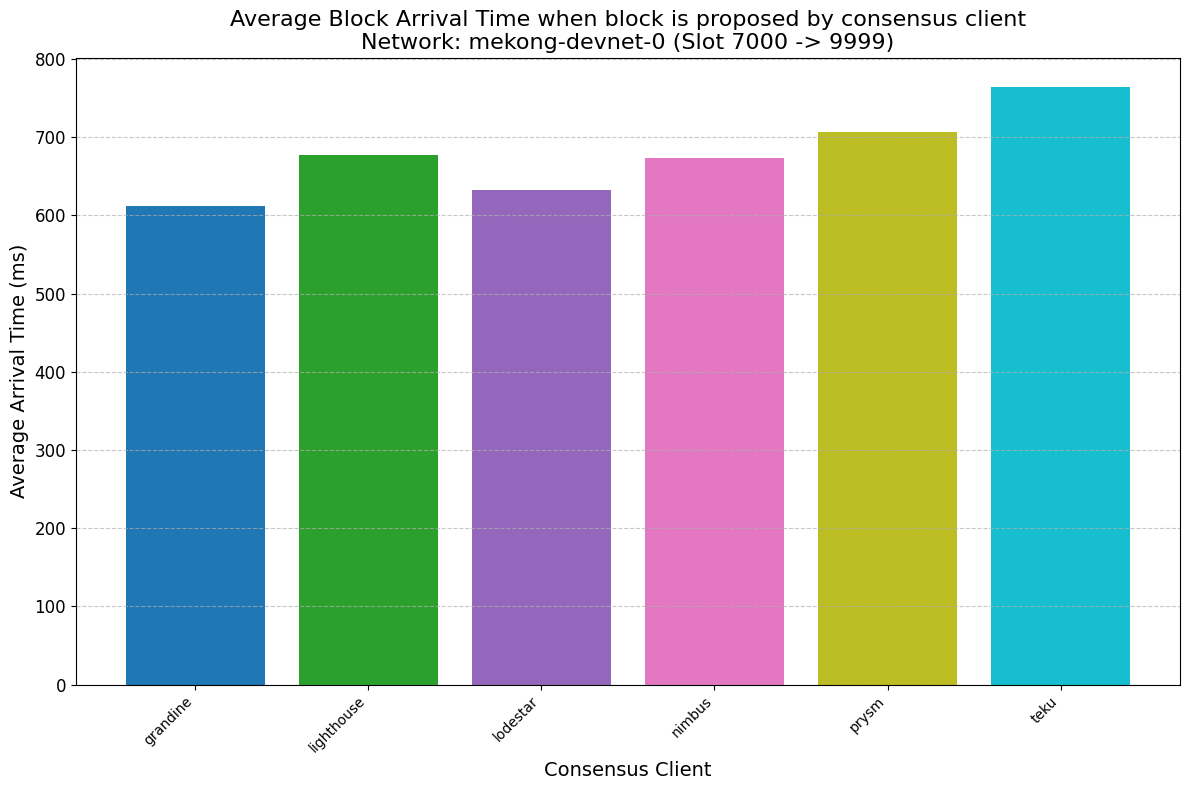

In [110]:
# Calculate average arrival time for each consensus client
client_arrival_times = {}
client_block_counts = {}

for node, blocks in node_blocks.items():
    client = node.split('-')[0]
    for block in blocks:
        if client not in client_arrival_times:
            client_arrival_times[client] = 0
            client_block_counts[client] = 0
        client_arrival_times[client] += block['arrival_stats'].avg
        client_block_counts[client] += 1

avg_client_arrival_times = {client: total_time / client_block_counts[client] 
                            for client, total_time in client_arrival_times.items()}

# Sort clients alphabetically
sorted_clients = sorted(avg_client_arrival_times.keys())

# Prepare data for plotting
arrival_times = [avg_client_arrival_times[client] for client in sorted_clients]

# Create a color palette based on consensus clients
unique_clients = sorted(set(sorted_clients))
color_palette = plt.colormaps['tab10'](np.linspace(0, 1, len(unique_clients)))
colors = [color_palette[unique_clients.index(client)] for client in sorted_clients]

# Plotting
plt.figure(figsize=(12, 8))
bars = plt.bar(sorted_clients, arrival_times, color=colors)

# Customize the plot
plt.title(f"Average Block Arrival Time when block is proposed by consensus client\nNetwork: {network} (Slot {min_slot} -> {max_slot})", 
          fontsize=16)
plt.xlabel("Consensus Client", fontsize=14)
plt.ylabel("Average Arrival Time (ms)", fontsize=14)
plt.xticks(rotation=45, ha='right', fontsize=10)
plt.yticks(fontsize=12)

# Add a grid for better readability
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Improve layout and show plot
plt.tight_layout()
plt.show()

# Uncomment to print detailed results
# for client in sorted_clients:
#     print(f"Average arrival time for {client}: {avg_client_arrival_times[client]:.2f} ms")

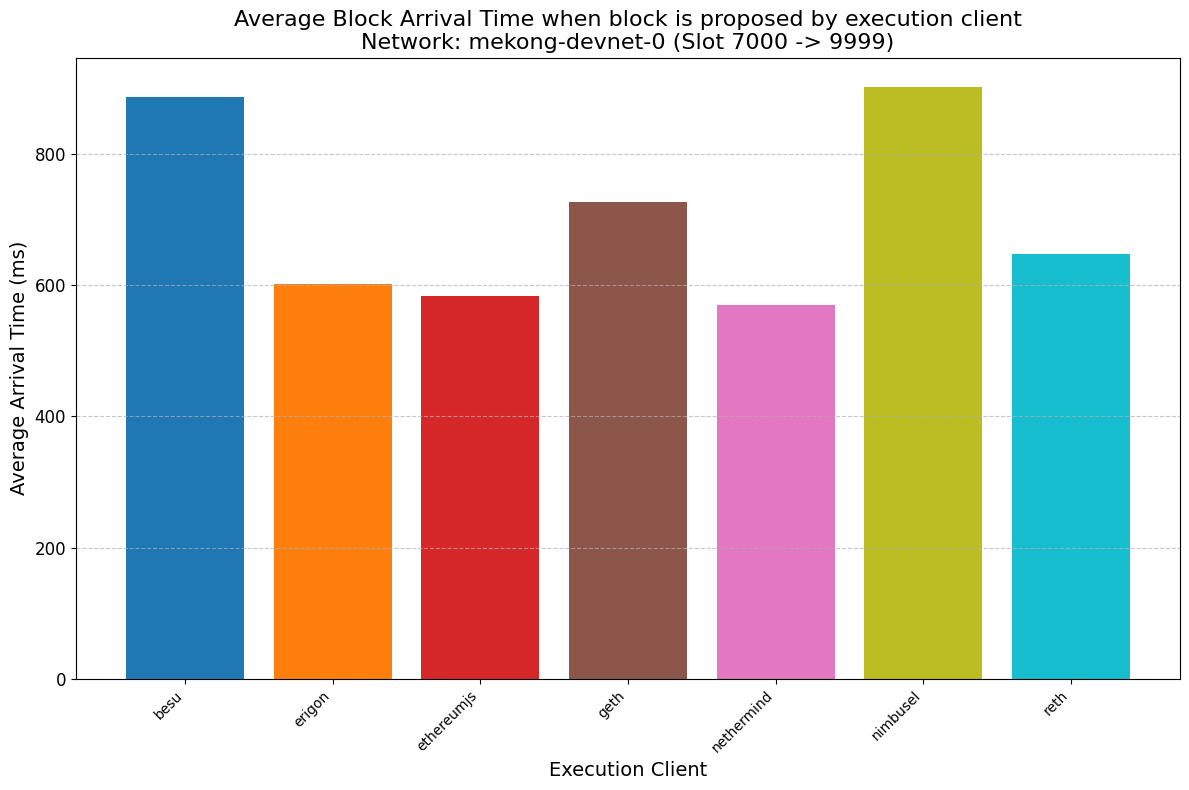

In [111]:
# Calculate average arrival time for each execution client
execution_client_arrival_times = {}
execution_client_block_counts = {}

for node, blocks in node_blocks.items():
    execution_client = node.split('-')[1]  # Assuming the execution client name is the second part of the node name
    for block in blocks:
        if execution_client not in execution_client_arrival_times:
            execution_client_arrival_times[execution_client] = 0
            execution_client_block_counts[execution_client] = 0
        execution_client_arrival_times[execution_client] += block['arrival_stats'].avg
        execution_client_block_counts[execution_client] += 1

avg_execution_client_arrival_times = {client: total_time / execution_client_block_counts[client] 
                                      for client, total_time in execution_client_arrival_times.items()}

# Sort execution clients alphabetically
sorted_execution_clients = sorted(avg_execution_client_arrival_times.keys())

# Prepare data for plotting
arrival_times = [avg_execution_client_arrival_times[client] for client in sorted_execution_clients]

# Create a color palette based on execution clients
unique_execution_clients = sorted(set(sorted_execution_clients))
color_palette = plt.colormaps['tab10'](np.linspace(0, 1, len(unique_execution_clients)))
colors = [color_palette[unique_execution_clients.index(client)] for client in sorted_execution_clients]

# Plotting
plt.figure(figsize=(12, 8))
bars = plt.bar(sorted_execution_clients, arrival_times, color=colors)

# Customize the plot
plt.title(f"Average Block Arrival Time when block is proposed by execution client\nNetwork: {network} (Slot {min_slot} -> {max_slot})", 
          fontsize=16)
plt.xlabel("Execution Client", fontsize=14)
plt.ylabel("Average Arrival Time (ms)", fontsize=14)
plt.xticks(rotation=45, ha='right', fontsize=10)
plt.yticks(fontsize=12)

# Add a grid for better readability
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Improve layout and show plot
plt.tight_layout()
plt.show()

# Uncomment to print detailed results
# for client in sorted_execution_clients:
#     print(f"Average arrival time for {client}: {avg_execution_client_arrival_times[client]:.2f} ms")

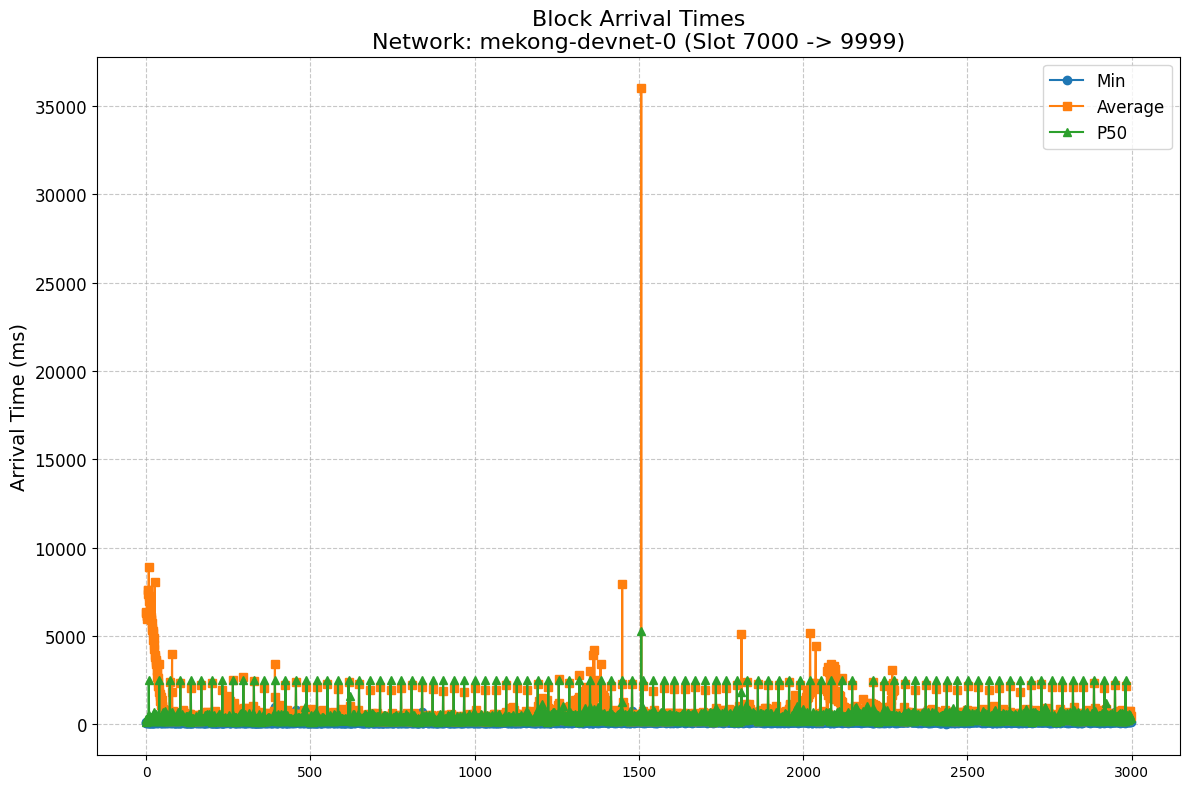

In [112]:
# Get stats for each slot
slots = sorted(block_arrival_times_dict.keys())

slots_data = {
    'min': [],
    'avg': [],
    'p50': []
}

for slot in slots:
    slots_data['min'].append(block_arrival_times_dict[slot].min)
    slots_data['avg'].append(block_arrival_times_dict[slot].avg) 
    slots_data['p50'].append(block_arrival_times_dict[slot].p50)

# Plotting
plt.figure(figsize=(12, 8))
plt.plot(slots_data['min'], marker='o', label='Min')
plt.plot(slots_data['avg'], marker='s', label='Average') 
plt.plot(slots_data['p50'], marker='^', label='P50')

# Customize the plot
plt.title(f"Block Arrival Times\nNetwork: {network} (Slot {min_slot} -> {max_slot})", 
          fontsize=16)
plt.ylabel("Arrival Time (ms)", fontsize=14)
plt.yticks(fontsize=12)
plt.legend(fontsize=12)

# Add a grid for better readability
plt.grid(True, linestyle='--', alpha=0.7)

# Improve layout and show plot
plt.tight_layout()
plt.show()

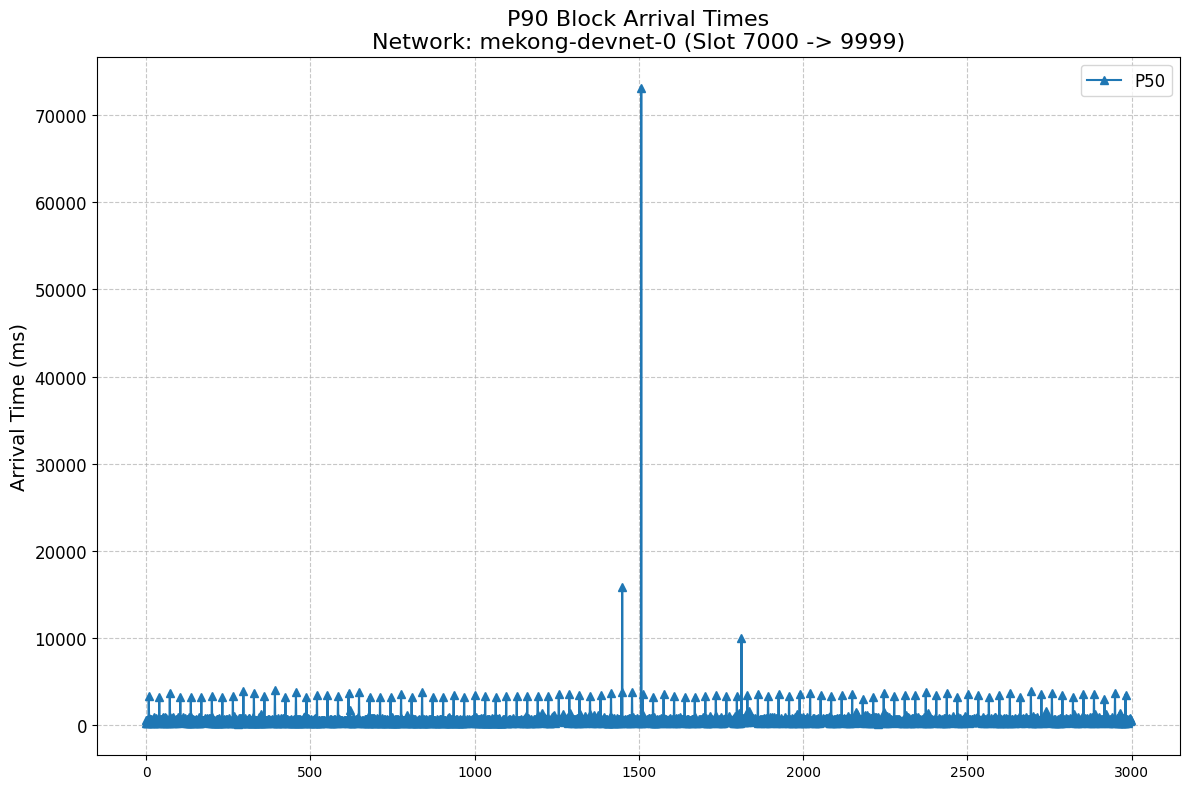

In [113]:
# Get stats for each slot
slots = sorted(block_arrival_times_dict.keys())

slots_data = {
    'p90': []
}

for slot in slots:
    slots_data['p90'].append(block_arrival_times_dict[slot].p90)

# Plotting
plt.figure(figsize=(12, 8))
plt.plot(slots_data['p90'], marker='^', label='P50')

# Customize the plot
plt.title(f"P90 Block Arrival Times\nNetwork: {network} (Slot {min_slot} -> {max_slot})", 
          fontsize=16)
plt.ylabel("Arrival Time (ms)", fontsize=14)
plt.yticks(fontsize=12)
plt.legend(fontsize=12)

# Add a grid for better readability
plt.grid(True, linestyle='--', alpha=0.7)

# Improve layout and show plot
plt.tight_layout()
plt.show()

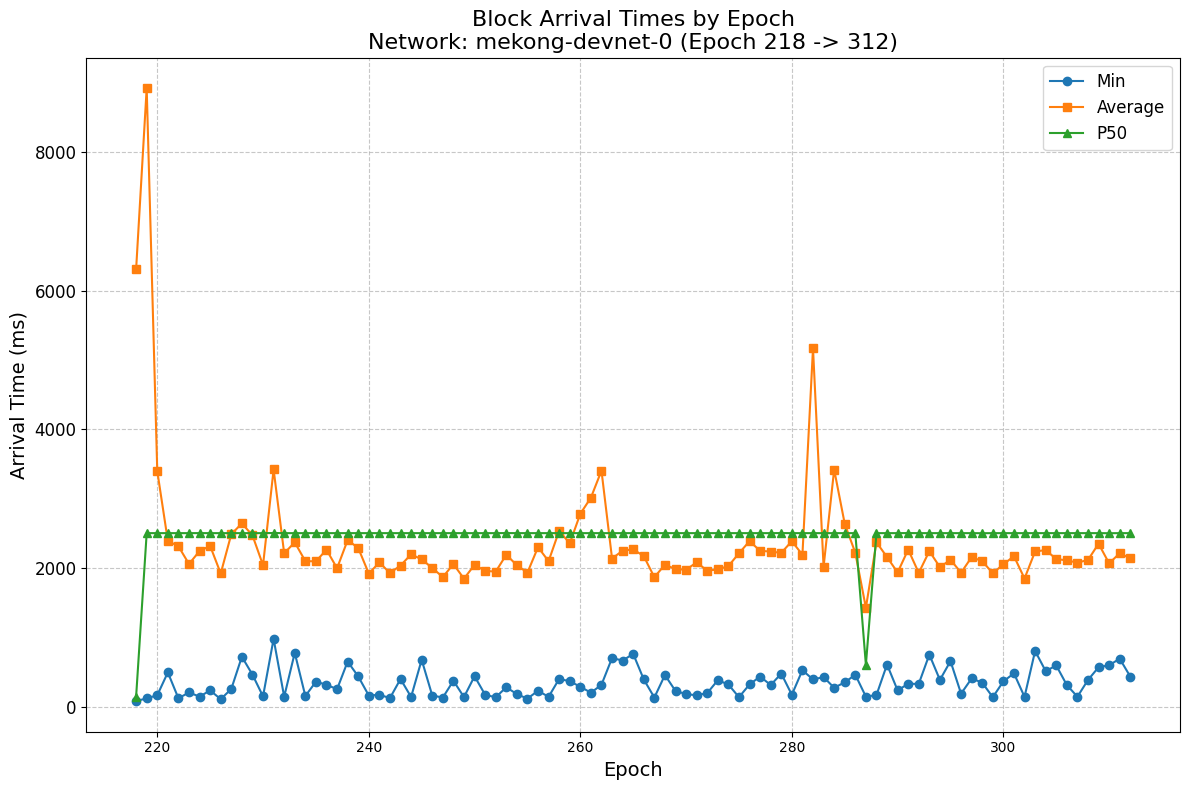

In [114]:
# Calculate epochs
SLOTS_PER_EPOCH = 32
min_epoch = min_slot // SLOTS_PER_EPOCH
max_epoch = max_slot // SLOTS_PER_EPOCH

# Get stats for each epoch
epochs = []
epoch_data = {
    'min': [],
    'avg': [],
    'p50': []
}

for slot in slots:
    epoch = slot // SLOTS_PER_EPOCH
    if epoch not in epochs:
        epochs.append(epoch)
        epoch_data['min'].append(block_arrival_times_dict[slot].min)
        epoch_data['avg'].append(block_arrival_times_dict[slot].avg)
        epoch_data['p50'].append(block_arrival_times_dict[slot].p50)

# Plotting
plt.figure(figsize=(12, 8))
plt.plot(epochs, epoch_data['min'], marker='o', label='Min')
plt.plot(epochs, epoch_data['avg'], marker='s', label='Average')
plt.plot(epochs, epoch_data['p50'], marker='^', label='P50')

# Customize the plot
plt.title(f"Block Arrival Times by Epoch\nNetwork: {network} (Epoch {min_epoch} -> {max_epoch})", 
          fontsize=16)
plt.xlabel("Epoch", fontsize=14)
plt.ylabel("Arrival Time (ms)", fontsize=14)
plt.xticks(fontsize=10)
plt.yticks(fontsize=12)
plt.legend(fontsize=12)

# Add a grid for better readability
plt.grid(True, linestyle='--', alpha=0.7)

# Improve layout and show plot
plt.tight_layout()
plt.show()